In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import csv
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

In [13]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.learner import cnn_config
from fastai.vision.models.unet import _get_sfs_idxs

from torchvision.models import vgg16_bn

In [5]:
path = Path('/data/Datasets/EIPH_WSI/Patches/')
src = ImageImageList.from_folder(path, recurse=True).random_split_by_pct(0.1, seed=42)

In [6]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: x)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(do_y=True))

    data.c = 3
    return data

In [7]:
data = get_data(64,64)

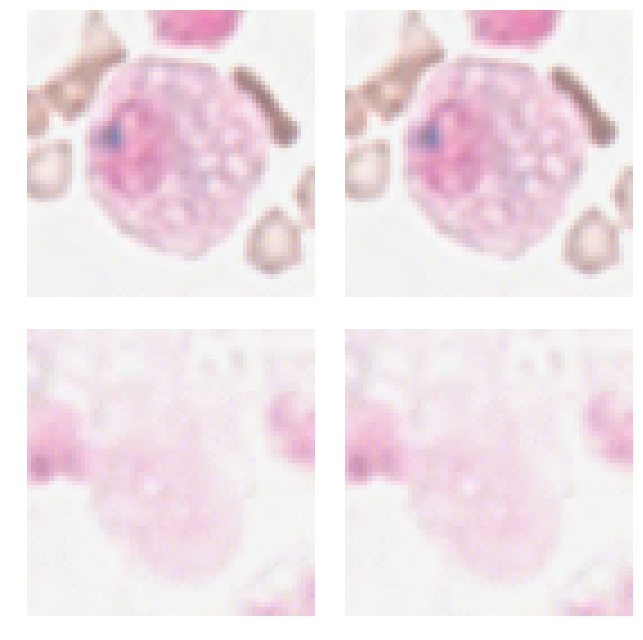

In [8]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

### Loss

In [9]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [10]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [11]:
base_loss = F.l1_loss

In [14]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [15]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [16]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [17]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

### Autoencoder

In [18]:
class DecoderBlock(nn.Module):
    
    def __init__(self, up_in_c:int, x_in_c:int, bilinear:bool=False, leaky:float=None,
                 self_attention:bool=False, **kwargs):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(up_in_c, x_in_c, 2, stride=2)

        self.conv1 = conv_layer(x_in_c, x_in_c, leaky=leaky, **kwargs)
        self.conv2 = conv_layer(x_in_c, x_in_c, leaky=leaky, self_attention=self_attention, **kwargs)
        self.relu = relu(leaky=leaky)

    def forward(self, up_in:Tensor) -> Tensor:
        up_out = self.up(up_in)

        x = self.relu(up_out)
        return self.conv2(self.conv1(x))

In [19]:
class BottleNeck(nn.Module):

    def __init__(self, ni: int, middle_nf: int=32, **kwargs):
        super().__init__()

        self.middle_in = conv_layer(ni, middle_nf, **kwargs)
        self.bn = batchnorm_2d(ni)
        self.relu = nn.ReLU()

    def forward(self, x):

        x = self.relu(self.bn(x))
        return self.middle_in(x)
    
class Decoder(nn.Module):

    def __init__(self, steps: int, middle_nf: int=32, middle_nf_out: int=512, channels_out: int=3, **kwargs):
        super().__init__()

        self.middle_out = conv_layer(middle_nf, middle_nf_out, **kwargs)

        self.up_path = []
        up_in_c = middle_nf_out
        for step in range(steps):
            x_in_c = up_in_c // 2

            decoder_block = DecoderBlock(up_in_c, x_in_c, **kwargs).eval()
            self.up_path.append(decoder_block)

            up_in_c = x_in_c


        self.up_path = nn.Sequential(*self.up_path)
        self.final = conv_layer(x_in_c, channels_out, ks=1, use_activ=False, **kwargs)

    def forward(self, x):

        x = self.middle_out(x)
        x = self.up_path(x)
        return self.final(x)

In [20]:
class AutoEncoder(nn.Module):
    def __init__(self, arch=models.resnet18, channels_out: int=3, middle_nf: int=32):
        super().__init__()
        self.feature_extractor = create_body(arch)

        imsize = (256,256)
        sfs_szs = model_sizes(self.feature_extractor, size=imsize)
        x = dummy_eval(self.feature_extractor, imsize).detach()

        x1, steps = x.shape[-1], 0
        while x1 < imsize[0]:
            x1 *= 2
            steps += 1

        ni = sfs_szs[-1][1]
        self.bottle_neck = BottleNeck(ni, middle_nf)
        self.decoder = Decoder(steps, middle_nf, ni, channels_out)

    def forward(self, im):

        x = self.feature_extractor(im)
        x = self.bottle_neck(x)
        x = self.decoder(x)

        return x

In [21]:
data = get_data(64, 128)
arch = models.resnet18

In [22]:
middle_nf = 8

meta = cnn_config(arch)
body = create_body(arch)
model = to_device(AutoEncoder(arch, channels_out=data.c, middle_nf=middle_nf), data.device)
learn = Learner(data, model, loss_func=feat_loss, callback_fns=[ShowGraph, LossMetrics]) # feat_loss #LossMetrics #F.l1_loss
learn.split([learn.model.feature_extractor, learn.model.bottle_neck, learn.model.decoder])
learn.freeze_to(-2)

apply_init(model.bottle_neck, nn.init.kaiming_normal_)
apply_init(model.decoder, nn.init.kaiming_normal_)

In [23]:
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


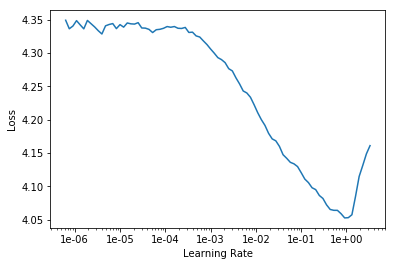

In [24]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,2.327901,2.677912,0.491169,0.321830,0.320512,0.093106,0.505998,0.837961,0.107336
2,2.257110,2.297364,0.352596,0.311714,0.297025,0.084481,0.404467,0.749122,0.097959
3,2.225201,3.539369,0.405990,0.305092,0.312095,0.087713,0.789582,1.530572,0.108325
4,2.197056,2.439627,0.314302,0.303607,0.297034,0.087586,0.487362,0.846621,0.103114
5,2.191076,9.607189,0.396631,0.313225,0.300715,0.086829,3.468055,4.881698,0.160037
6,2.137028,2.506729,0.277027,0.298689,0.286941,0.081877,0.502082,0.960773,0.099340
7,2.118658,2.170926,0.272892,0.296588,0.285248,0.082563,0.391986,0.745371,0.096278
8,2.075489,26.110577,0.336111,0.298984,0.289063,0.081040,8.066923,16.775957,0.262498
9,2.036992,2.126096,0.242088,0.290564,0.272477,0.078548,0.391566,0.756936,0.093917
10,2.027241,2.165476,0.239994,0.291050,0.269728,0.078011,0.405034,0.787827,0.093832


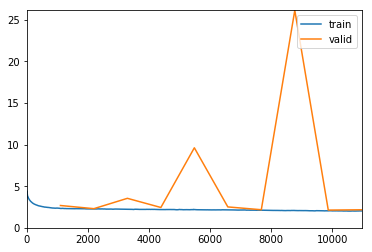

In [25]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,2.042720,2.304892,0.258559,0.291923,0.272838,0.078941,0.444219,0.862750,0.095661
2,2.051460,2.134772,0.261936,0.293875,0.273752,0.079272,0.388911,0.742834,0.094190
3,2.027035,111.675934,0.377648,0.296210,0.285527,0.079911,36.260597,73.421867,0.954143
4,2.014944,82.017136,0.338657,0.295541,0.280730,0.078810,26.592529,53.786152,0.644753
5,2.002952,14.971625,0.274609,0.291327,0.271539,0.077784,4.419175,9.421228,0.215962


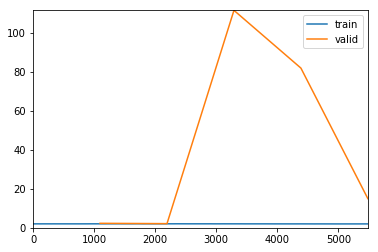

In [26]:
learn.unfreeze()
lr = 1e-2
learn.fit_one_cycle(5, slice(1e-5,lr/5))

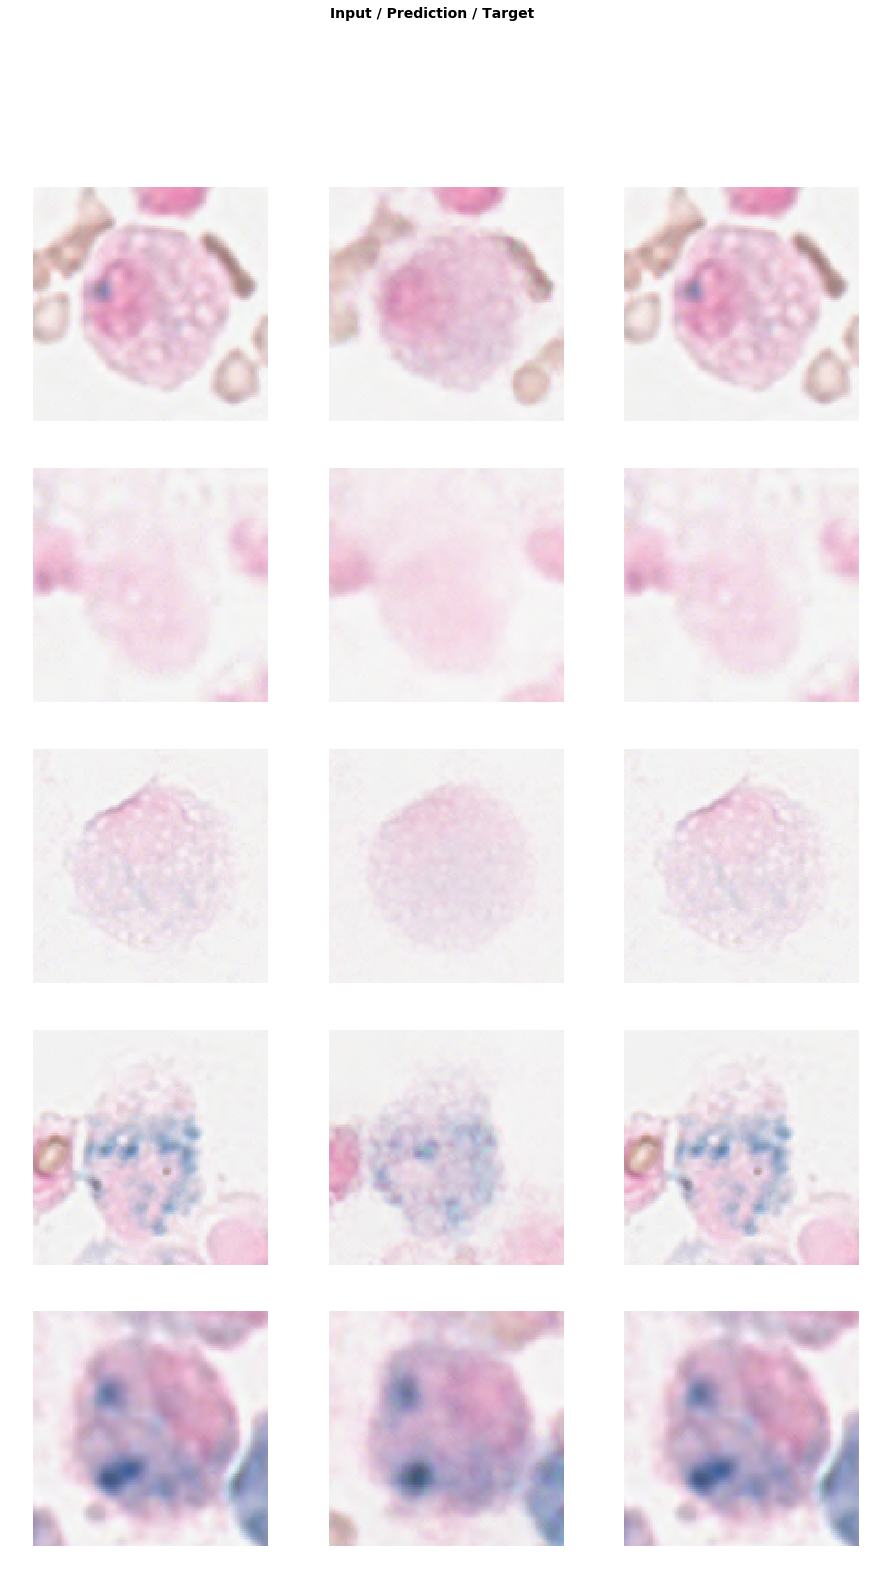

In [27]:
learn.show_results(rows=5, imgsize=5)

In [28]:
learn.model = nn.Sequential(*[learn.model.feature_extractor, learn.model.bottle_neck])
result = learn.get_preds(ds_type=DatasetType.Valid)

In [31]:
rep_x = []
rep_y = []

for fn, features in zip(learn.data.valid_dl.items, to_np(result[0])):
    
    rep_y.append(int(fn.parent.stem))
    rep_x.append(features.flatten())

rep_x = np.array(rep_x)
rep_y = np.array(rep_y)

In [38]:
from sklearn.manifold import TSNE
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    for i in set(y1): 
        plt.scatter(X_t[np.where(y1 == i), 0], X_t[np.where(y1 == i), 1], marker='o', linewidth='1', alpha=0.8, label=str(i))

    plt.legend(loc='best');
    #plt.savefig(name);
    plt.show();

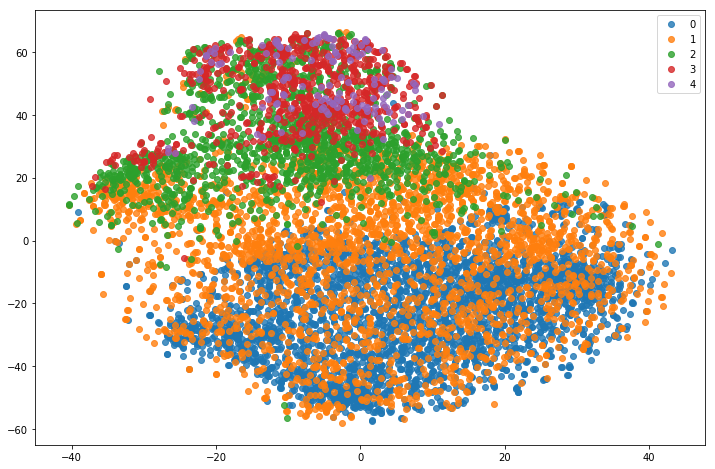

In [39]:
tsne_plot(rep_x, rep_y, "latent_representation.png")